In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def load_image(file):
    result =  cv2.imread(file)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result
    
def convert_color(img,cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            result = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            result = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            result = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            result = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            result = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: result = np.copy(img)
    
    return result 

def draw_boxes(img, bboxes, color=None, thick=2):

    draw_img = np.copy(img)
    
    for bbox in bboxes:
        (x1, y1), (x2, y2) = bbox
        
        if color == None:
            rectangle_color = (
                random.randint(0,255),
                random.randint(0,255),
                random.randint(0,255))
        else:
            rectangle_color = color
        
        cv2.rectangle(draw_img, (x1, y1), (x2, y2), rectangle_color, thick)

    return draw_img 

def normalize_image(img):
    return img / 255


In [2]:
from skimage.feature import hog

def get_hog_vector(hog_features):
    return np.hstack((
            hog_features[0].ravel(), 
            hog_features[1].ravel(), 
            hog_features[2].ravel()))
        

def get_hog_features(
        img,
        cspace,
        orientations, 
        pix_per_cell, 
        cell_per_block):
    
    img = convert_color(img,cspace)
    img = normalize_image(img)
    
    results = []
    
    for channel in range(img.shape[2]):
        
        image = img[:,:,channel]
 
        features = hog(
            image, 
            orientations=orientations,
            pixels_per_cell=(pix_per_cell, pix_per_cell), 
            cells_per_block=(cell_per_block, cell_per_block), 
            visualise=False, 
            feature_vector=False,
            block_norm="L2-Hys",
            transform_sqrt = False)
        
        results.append(features)
    
    result = np.array(results)
    
    return result


def get_spatial_features(image, color_space, size=(32, 32)):
 
    img = convert_color(image,color_space)
    img = cv2.resize(img, size)
    img = normalize_image(img)
    
    features = img.ravel() 

    return features

 
def get_color_histogram_features(image, color_space, nbins=32, bins_range=(0, 256)):
    
    img = convert_color(image,color_space)
    
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    return features


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import glob

def extract_features(files,get_features):
    
    features = []
        
    for file in files:
        
        image = load_image(file)
        
        features.append(get_features(image))
        
    return np.array(features)


def get_training_files(trainingset='largeset'):
    
    images = glob.glob('data/*{0}/*/*.*'.format(trainingset))
    
    cars = []
    notcars = []
    
    for image in images:
        if 'non-vehicles' in image:
            notcars.append(image)
        else:
            cars.append(image)

    return cars, notcars

  
def train(get_features):
     
    cars, notcars = get_training_files(trainingset='largeset')
      
    car_features = extract_features(
                            cars,
                            get_features)
    
    notcar_features = extract_features(
                            notcars,
                            get_features)
    
    y = np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
        
    X_scaler = StandardScaler().fit(X)

    scaled_X = X_scaler.transform(X)

    rand_state = np.random.randint(0, 100)
    
    
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, 
        y, 
        test_size=0.2, 
        random_state=rand_state)

    svc = LinearSVC()

    svc.fit(X_train, y_train) 
    
    print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
    
    def predict(image,hog_features=[]):
    
        features = get_features(image,hog_features)

        scaled = X_scaler.transform(features.reshape(1,-1))
    
        return np.int(svc.predict(scaled)) == 1
    
    return predict

In [4]:
def build_get_features(
    cspace,
    orientations,
    pix_per_cell,
    cell_per_block):
    
    def create_features(image,hog_features = []):
        
        spatial_features = get_spatial_features(image,cspace)
        color_histogram_features = get_color_histogram_features(image,cspace)
        
        if len(hog_features) == 0:    
            hog_features = get_hog_features(
                image,
                cspace = cspace,
                orientations = orientations,
                pix_per_cell = pix_per_cell,
                cell_per_block = cell_per_block)
              
        features = np.concatenate((
            get_hog_vector(hog_features),
            spatial_features.astype(np.float64),
            color_histogram_features.astype(np.float64)
            ))
        
            
        return features
    
    return create_features

get_image_features = build_get_features(
    cspace = 'YUV',
    orientations = 11,
    pix_per_cell = 16,
    cell_per_block = 2)

predict = train(get_image_features)

Test Accuracy of SVC =  0.990427927928


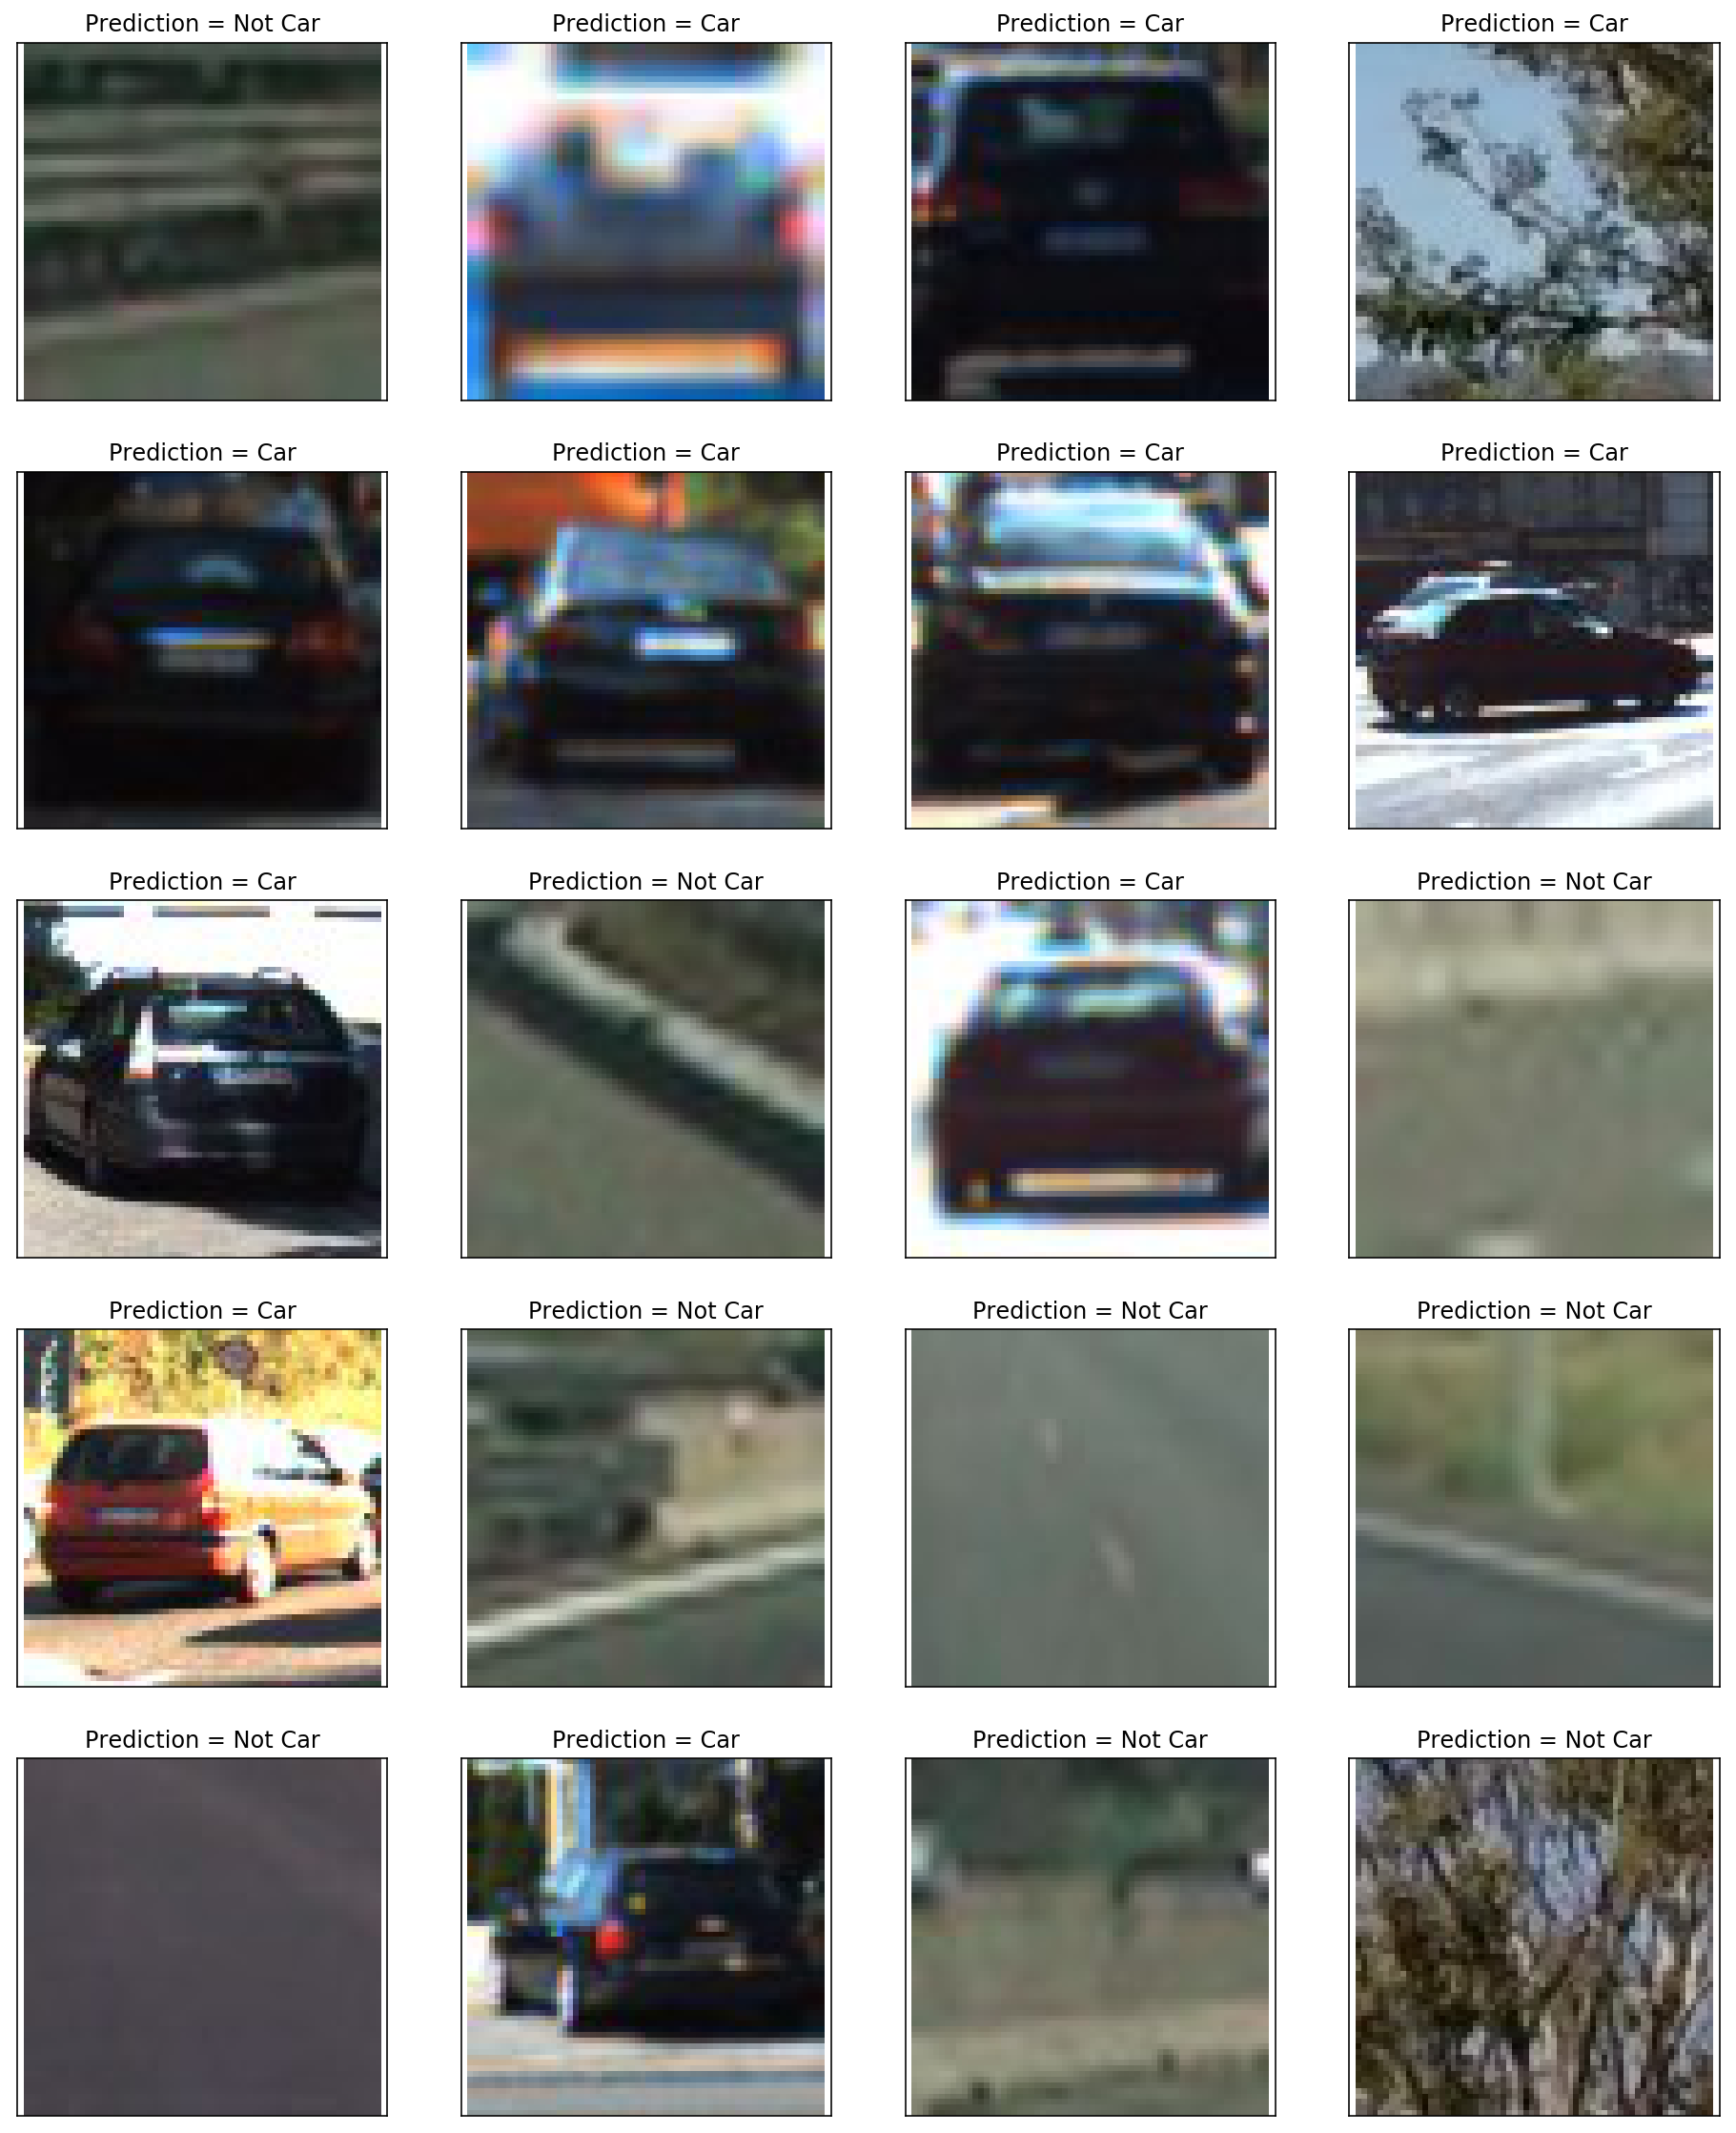

In [6]:
def show_predictons(rows, columns):

    cars, notcars = get_training_files(trainingset='smallset')
    
    files = np.array(cars + notcars)
    
    indexes = np.random.randint(0,len(files),rows * columns)
    
    def get_label(image):
        isCar = predict(image)
        if isCar:
            return 'Car'
        else:
            return 'Not Car'
    
    
    
    images = [load_image(file) for file in files[indexes]]
    
    labels = [get_label(image) for image in images]
    
    fig, axes = plt.subplots(
        nrows = rows, 
        ncols = columns, 
        sharex=True, 
        sharey=True, 
        figsize=(4 * columns, 4 * rows)
    )

    for ii, ax in enumerate(axes.flatten()):
        ax.imshow(images[ii])
        title = "Prediction = {0}".format(labels[ii])
        ax.set_title(title)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    
    
show_predictons(rows = 5, columns = 4)

In [7]:
import math

def convert_scale(image,scale):
    height,width = np.int(image.shape[0]/scale), np.int(image.shape[1]/scale)
    image = cv2.resize(image,(width,height))
    return image

def hog_sliding_windows(
        img,
        x_range,
        y_range,
        scale,
        cspace,
        cell_per_step,
        orientations,
        pix_per_cell,
        cell_per_block,
        block_per_window):
        
    window = block_per_window * cell_per_block * pix_per_cell
    
    cell_per_step_x, cell_per_step_y = cell_per_step
    
    x_start,x_stop = x_range
    y_start,y_stop = y_range
    
    image = np.copy(img)
    image = image[y_start:y_stop,x_start:x_stop,:]
    image = convert_scale(image,scale)
    
    height,width,_ = image.shape
    
    hog_features = get_hog_features(
        image,
        cspace,
        orientations, 
        pix_per_cell, 
        cell_per_block)


    nxblocks = (width // pix_per_cell - cell_per_block) + 1
    nyblocks = (height // pix_per_cell - cell_per_block) + 1 
        
    nblocks_per_window = (window // pix_per_cell - cell_per_block) + 1
  
    nxsteps = math.ceil((nxblocks - nblocks_per_window + 1) / cell_per_step_x)
    nysteps = math.ceil((nyblocks - nblocks_per_window + 1) / cell_per_step_y)
    
    for xb in range(nxsteps):
            
        for yb in range(nysteps):
            
            ypos = yb * cell_per_step_y
            xpos = xb * cell_per_step_x
        
            features = hog_features[:, ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window]
         
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            subimg = image[ytop:ytop+window, xleft:xleft+window]
            
            features = get_hog_features(
                subimg,
                cspace,
                orientations, 
                pix_per_cell, 
                cell_per_block)
            
       
            xbox_left = np.int(xleft * scale) + x_start
            ybox_top = np.int(ytop * scale) + y_start
            box_width = np.int(window * scale)
            
    
            box_coordinates = ((xbox_left, ybox_top),(xbox_left + box_width, ybox_top + box_width))

            yield box_coordinates, features, subimg
            
            

In [8]:
def build_get_sliding_windows(
    scales,
    cspace,
    orientations,
    pix_per_cell,
    cell_per_block,
    block_per_window,
    cell_per_step):
    
    def get_sliding_windows(image):
    
        for scale in scales:
            x_min, x_max = 0, 1280
            y_min = 400
            y_max = np.int(400 + scale * 64)
            
            windows = hog_sliding_windows(
                      image,
                      (x_min, x_max),
                      (y_min,y_max),
                      scale,
                      cspace = cspace,
                      cell_per_step = cell_per_step,
                      orientations = orientations,
                      pix_per_cell = pix_per_cell,
                      cell_per_block = cell_per_block,
                      block_per_window = block_per_window)
            
            for window in windows:
                yield window
                
    return get_sliding_windows


In [9]:
def hog_sliding_window_test(file,scale):
    
    get_sliding_windows = build_get_sliding_windows(
        scales = [scale],
        cspace = 'YUV',
        orientations = 11,
        pix_per_cell = 16,
        cell_per_block = 2,
        block_per_window = 2,
        cell_per_step = (2,1))
    
    img = load_image(file)
        
    windows = get_sliding_windows(img)
    
    boxes = [box for box, features, subimg in windows]
    
    result = draw_boxes(img,boxes,thick=4)
    
    #plt.figure(figsize=(8,8))
    plt.imshow(result)
    plt.show()

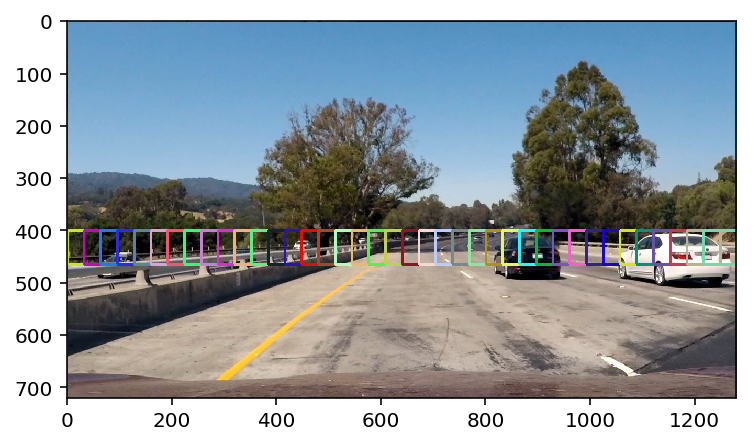

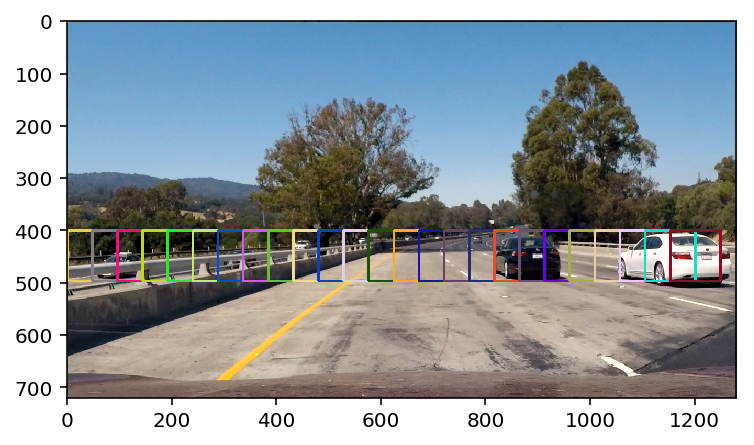

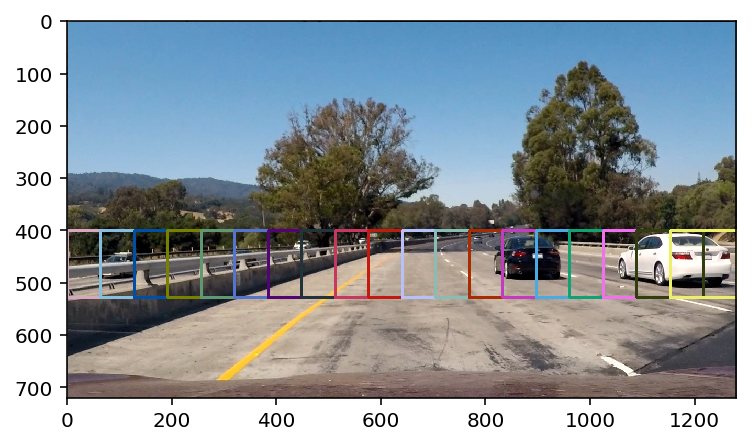

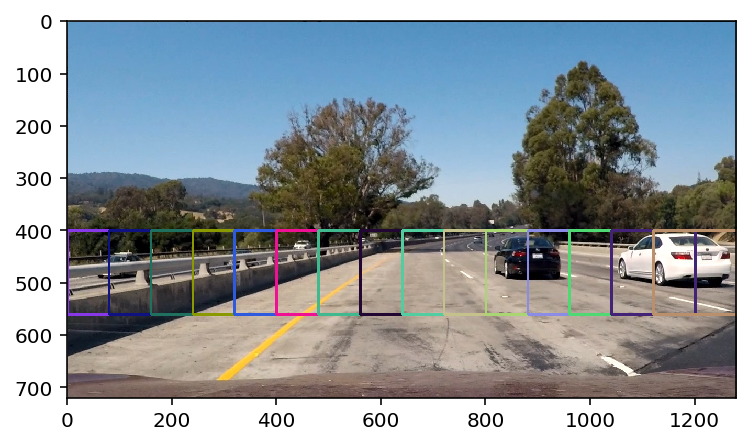

In [12]:
hog_sliding_window_test('test_images/test1.jpg',scale=1)
hog_sliding_window_test('test_images/test1.jpg',scale=1.5)
hog_sliding_window_test('test_images/test1.jpg',scale=2)
hog_sliding_window_test('test_images/test1.jpg',scale=2.5)

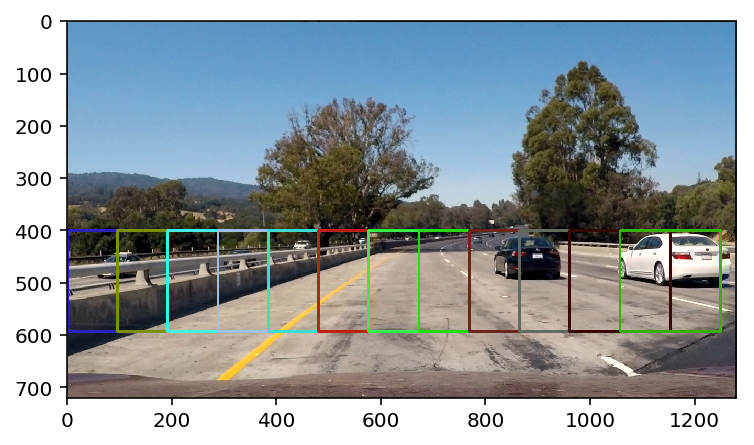

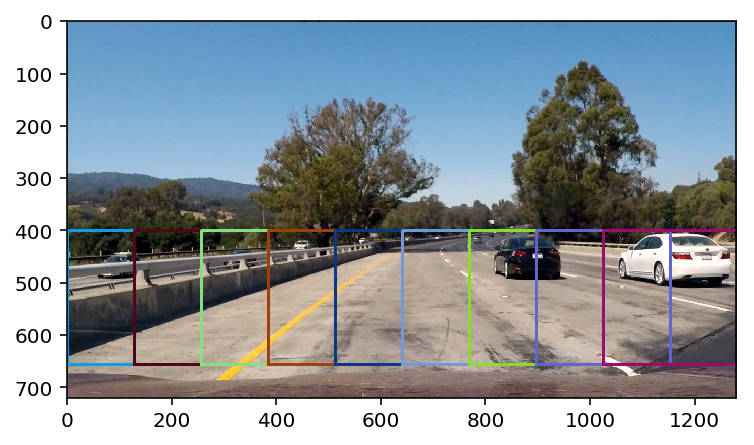

In [13]:
hog_sliding_window_test('test_images/test1.jpg',scale=3)
hog_sliding_window_test('test_images/test1.jpg',scale=4)

In [14]:
def build_get_matching_boxes(get_sliding_windows):
    
    def get_matching_boxes(image):
        
        matches = []
        
        windows = get_sliding_windows(image)
    
        for box, features, subimg in windows:
            if(predict(subimg,features)):
                matches.append(box)
                
        return matches
    
    return get_matching_boxes

In [35]:
def get_matching_boxes_test(file):
    
    get_sliding_windows = build_get_sliding_windows(
        scales = [1,1.5,2,2.5,3,3.5,4],
        cspace = 'YUV',
        orientations = 11,
        pix_per_cell = 16,
        cell_per_block = 2,
        block_per_window = 2,
        cell_per_step = (2,1))
    
    get_matching_boxes = build_get_matching_boxes(get_sliding_windows)
    
    img = load_image(file)
    
    boxes = get_matching_boxes(img)
    
    result = draw_boxes(img,boxes,thick=4)
    
    #plt.figure(figsize=(8,8))
    plt.imshow(result)
    plt.show()

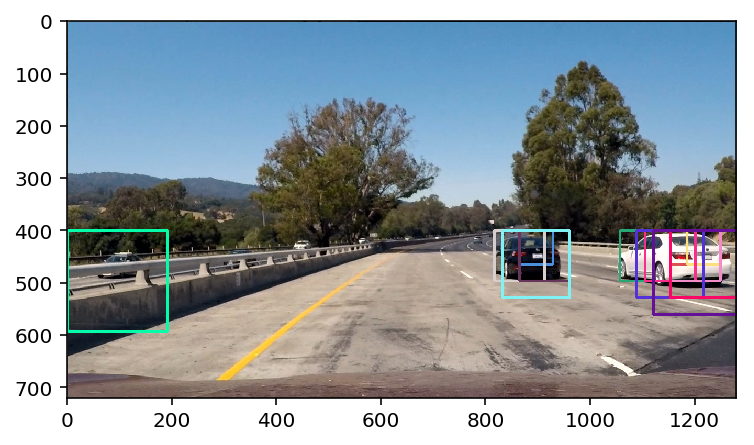

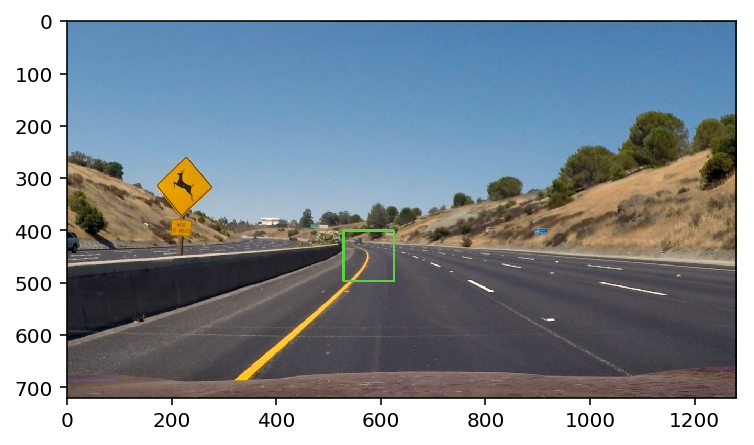

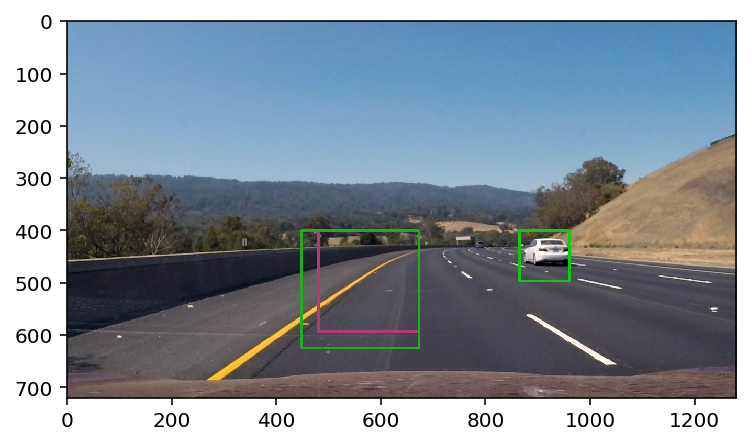

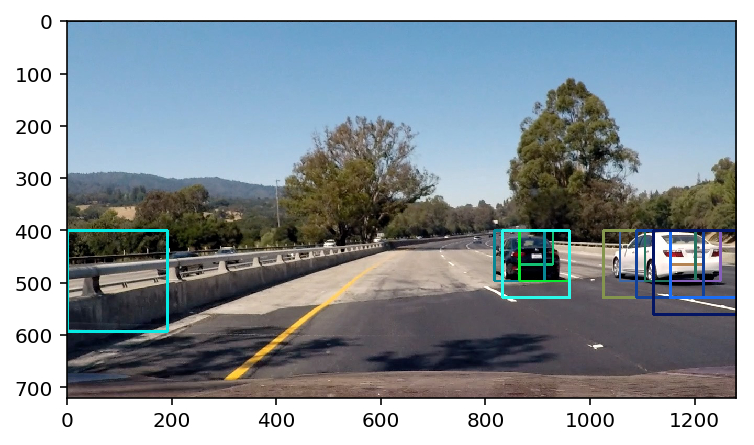

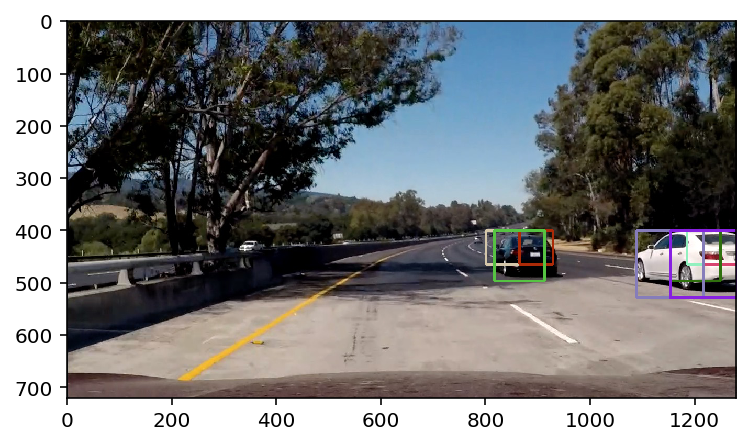

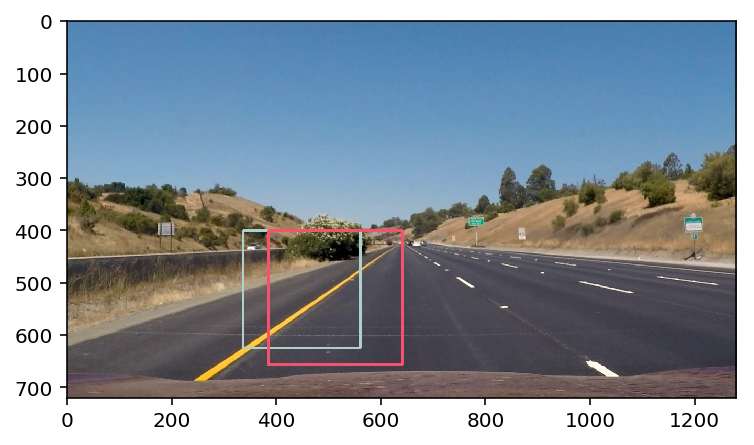

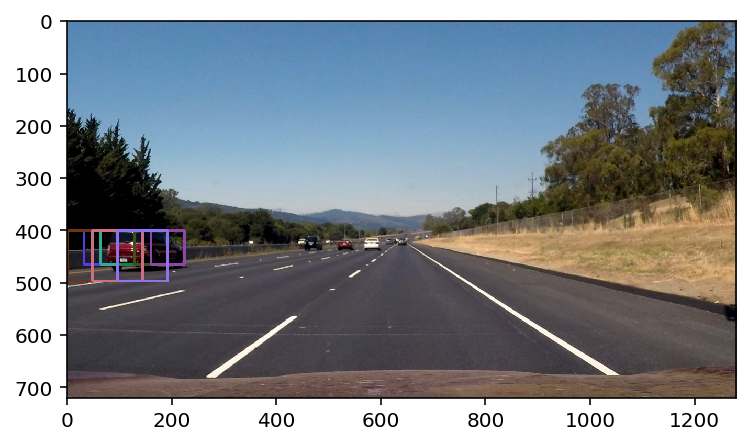

In [36]:
get_matching_boxes_test('test_images/test1.jpg')
get_matching_boxes_test('test_images/test2.jpg')
get_matching_boxes_test('test_images/test3.jpg')
get_matching_boxes_test('test_images/test4.jpg')
get_matching_boxes_test('test_images/test5.jpg')
get_matching_boxes_test('test_images/straight_lines1.jpg')
get_matching_boxes_test('test_images/straight_lines2.jpg')

In [ ]:
from scipy.ndimage.measurements import label

def add_heat(heatmap,boxes):
    for box in boxes:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def get_labeled_boxes(labels):
    
    results = []
    
    image,count = labels
    
    for i in range(0,count):
        
        nonzero = (image == i + 1).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

        results.append(bbox)

    return results

class Memory():
    def __init__(self,n):
        self._n = n
        self._maps = []
        
    def add_heatmap(self,heatmap):
        
        if len(self._maps) == 0:
            self._maps = [heatmap for i in range(self._n)]
        
        else:
            self._maps.insert(0,heatmap)
            self._maps.pop()

    
    def heatmap(self):
        return np.mean(self._maps, axis = 0)
    
def process_image(image,memory,n):
    
    print(np.max(image))
    print(np.min(image))
    #boxes = get_matching_boxes(image)
  #
    #heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    #add_heat(heatmap,boxes)
    #memory.add_heatmap(heatmap)
    #heatmap = memory.heatmap()
    #heatmap = apply_threshold(heatmap,1.5)
    #labels = label(heatmap)
#
    #bboxes = get_labeled_boxes(labels)
 #
    #result = draw_boxes(image, boxes, thick=2)
    return image

def create_process_image():
    
    n = 10
    memory = Memory(n)
    
    return lambda img : process_image(img,memory,n)



In [ ]:
image = mpimg.imread('test_images/test1.jpg')

process = create_process_image()
result = process(image)


plt.figure(figsize=(12,12))
plt.imshow(result)

In [ ]:
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
file = 'project_video.mp4'
white_output = 'output_videos/' + file

##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(file).subclip(0,1)

process = create_process_image()

white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)